In [84]:
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman'],
    'text.usetex': True
})

## Data Preprocessing
Adding up international and domestic inputs to each sector. Setting small values < CUTOFF to 0

In [85]:
# load dataset
country = 'DEU'
FILE_PATH = f'../NIOTS/{country}_NIOT_nov16.xlsx'
SHEET_NAME = 'National IO-tables'
YEAR = 2014
CUTOFF = 0.05 # set small values to 0

In [86]:
df = pd.read_excel(FILE_PATH, sheet_name=SHEET_NAME, header=0)
df.drop(0, inplace=True)
df = df[df['Year'] == YEAR]

# summing foreign imports and domestic imports
df_combined = pd.DataFrame()

for code in df['Code'].unique():
    rows = df[df['Code'] == code]
    combined_row = rows.iloc[0].copy()
    combined_row.iloc[2:] = rows.iloc[:, 2:].sum()
    df_combined = pd.concat([df_combined, combined_row.to_frame().T], ignore_index=True)
    
variable_descriptions = df.set_index('Code')['Description'].to_dict()

# dropping columns
columns = ['Year', 'Origin', 'CONS_h', 'CONS_np', 'CONS_g', 'GFCF', 'INVEN', 'EXP', 'GO', 'Description']
df_combined.drop(columns, inplace=True, axis=1)
df = df_combined    # renaming
column_names = df.columns.tolist()
df = df[df['Code'].isin(column_names)]
df.shape

# convert datatypes to float, except first column to string
df = df.astype({'Code': str})
df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
df.set_index('Code', inplace=True)

for i in range(df.shape[0]):    # setting diagonal to 0
    df.iloc[i, i] = 0
    
    # Identify columns with a sum of zero
column_sums = df.sum(axis=0)
zero_sum_columns = column_sums[column_sums == 0].index

# Drop columns with a sum of zero
df.drop(columns=zero_sum_columns, inplace=True)

# Recalculate column sums after dropping zero-sum columns
column_sums = df.sum(axis=0)

# Normalize by column sum
df = df.div(column_sums, axis=1)

df = df.drop(index=zero_sum_columns) # drop corresponding rows 

df = df.apply(pd.to_numeric, errors='coerce')
df.dropna(axis=0, how='any', inplace=True)
df.dropna(axis=1, how='any', inplace=True)

df[df < CUTOFF] = 0 # setting small values to 0

## Graph

In [87]:
# Create a directed graph representation
G = nx.from_pandas_adjacency(df, create_using=nx.DiGraph)

# Assign edge weights to the graph
for i, row in df.iterrows():
    for j, value in row.items():
        if value > 0:
            G[i][j]['weight'] = value

### Graph Measures

In [88]:
# Calculate the average shortest path length
# average_shortest_path_length = nx.average_shortest_path_length(G)
avg_path = nx.average_shortest_path_length(G.subgraph(max(nx.strongly_connected_components(G), key=len)))
diameter = nx.diameter(G.subgraph(max(nx.strongly_connected_components(G), key=len)))
avg_outdegree = np.mean(list(dict(G.out_degree()).values()))
num_nodes = G.number_of_nodes()
print(f"Average Longest Shortest Path: {avg_path:.3f}")
print(f"Diameter: {diameter}")
print(f"Average Outdegree: {avg_outdegree:.3f}")
print(f"Number of Nodes: {num_nodes}")

Average Longest Shortest Path: 2.825
Diameter: 6
Average Outdegree: 5.130
Number of Nodes: 54


### Outdegree Centrality

Most central sectors (outdegree centrality): ['N', 'G46', 'L68', 'M69_M70', 'H52']


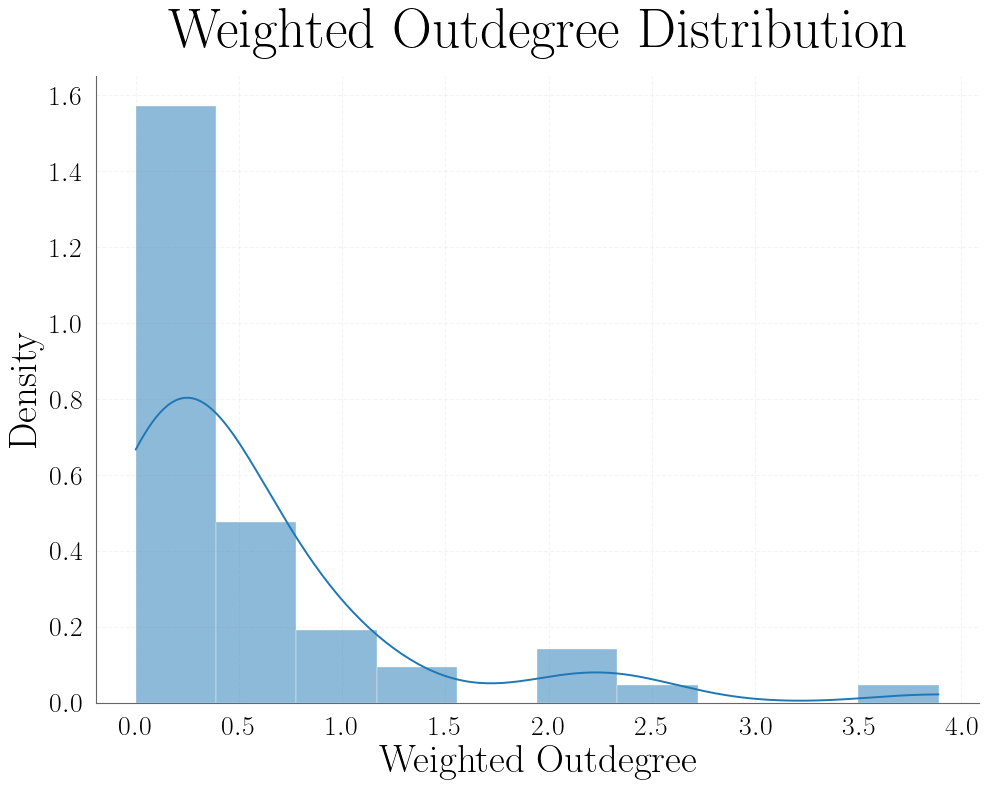

<Figure size 640x440 with 0 Axes>

In [89]:
# Calculate weighted outdegree distribution
weighted_outdegrees = dict(G.out_degree(weight='weight'))
weighted_outdegree_values = list(weighted_outdegrees.values())

top_sectors = sorted(weighted_outdegrees, key=weighted_outdegrees.get, reverse=True)[:5]
print(f"Most central sectors (outdegree centrality): {top_sectors}")

# # Plot the PDF of the weighted outdegree distribution
# plt.figure(figsize=(10, 6))
# sns.histplot(weighted_outdegree_values, bins=10, kde=True, stat="density")
# plt.xlabel('Weighted Outdegree')
# plt.ylabel('Density')
# plt.title(f'Weighted Outdegree Distribution for {country} in {YEAR}')
# plt.show()

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10, 8))

# Create histogram with KDE
sns.histplot(weighted_outdegree_values, bins=10, kde=True, stat="density", ax=ax, 
             alpha=0.5,  # Set alpha to 0.7 for the bins
             legend=False)  # Remove the legend

# Style the grid
ax.grid(True, which='major', linestyle='--', alpha=0.2)
ax.set_axisbelow(True)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Style the remaining spines
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')

# Style the axis labels and title with increased font sizes
ax.set_xlabel('Weighted Outdegree', fontsize=28, color='black')  # Increased fontsize
ax.set_ylabel('Density', fontsize=28, color='black')  # Increased fontsize
# ax.set_title(f'Weighted Outdegree Distribution for {country} in {YEAR}', 
#              fontsize=24, color='black', pad=20)  # Increased fontsize
ax.set_title(f'Weighted Outdegree Distribution', 
             fontsize=40, color='black', pad=20)  # Increased fontsize

# Style the ticks with increased font size
ax.tick_params(axis='both', which='major', labelsize=20, colors='black')  # Increased labelsize

# Add some padding
plt.tight_layout()
plt.show()

plt.savefig('plots/DEU_outdegree.png')

Share of top 5 nodes: 0.425


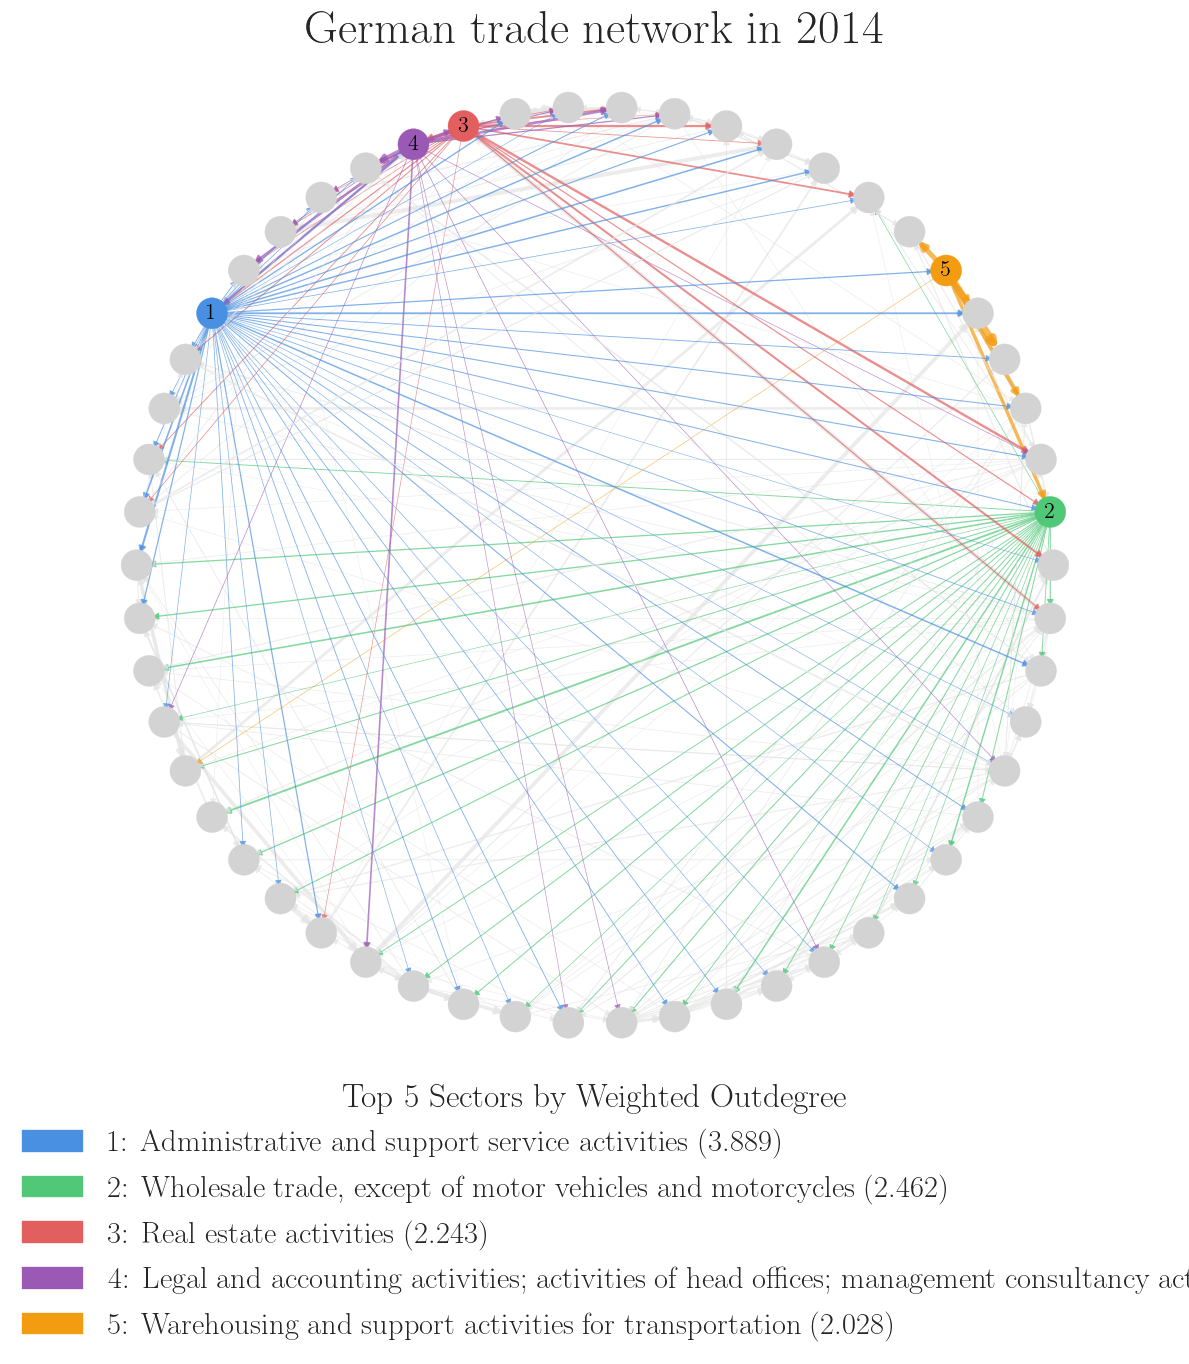

<Figure size 640x440 with 0 Axes>

In [90]:
# Identify the top 5 nodes with highest outdegree
top_5_nodes = sorted(weighted_outdegrees, key=weighted_outdegrees.get, reverse=True)[:5]

# Get share of top nodes
share = sum(weighted_outdegrees[node] for node in top_5_nodes)
print(f"Share of top 5 nodes: {share/sum(weighted_outdegree_values):.3f}")

# Define distinct colors for top 5 nodes with the specified colors
distinct_colors = {
    top_5_nodes[0]: '#4a90e2',  # blue
    top_5_nodes[1]: '#50c878',  # green
    top_5_nodes[2]: '#e35f5f',  # red
    top_5_nodes[3]: '#9b59b6',  # purple
    top_5_nodes[4]: '#f39c12',  # orange
}

# Create node colors list
node_colors = []
for node in G.nodes():
    if node in top_5_nodes:
        node_colors.append(distinct_colors[node])
    else:
        node_colors.append('#D3D3D3')  # light grey for other nodes

# Create edge colors based on source node
edge_colors = []
edges = G.edges(data=True)
for edge in edges:
    source = edge[0]
    if source in top_5_nodes:
        edge_colors.append(distinct_colors[source])
    else:
        edge_colors.append('#E5E5E5')  # very light grey for other edges

plt.figure(figsize=(12, 14))  # Adjusted to maintain square plot area with legend

# Create subplot for the network (square)
ax1 = plt.subplot2grid((13, 12), (0, 0), colspan=12, rowspan=12)
ax1.grid(False)  # Turn off grid for main plot
ax1.set_frame_on(False)  # Remove the box around the plot

# Calculate shell layout with equal aspect ratio
pos = nx.shell_layout(G)

# Ensure the plot is perfectly square
ax1.set_aspect('equal')

# Draw nodes
nx.draw_networkx_nodes(G, pos, 
                      node_color=node_colors,
                      node_size=500)

# Draw edges with increased width
edge_widths = [edge[2]['weight'] * 8 for edge in edges]
nx.draw_networkx_edges(G, pos, 
                      edgelist=edges, 
                      width=edge_widths, 
                      edge_color=edge_colors, 
                      alpha=0.7)

# Add labels for top 5 nodes (all in black)
for i, node in enumerate(top_5_nodes, start=1):
    x, y = pos[node]
    plt.text(x, y, str(i), fontsize=16, ha='center', va='center',  # Increased fontsize
             color='black',
             fontweight='bold')

# Create subplot for the legend (reduced vertical space)
ax2 = plt.subplot2grid((13, 12), (12, 0), colspan=12, rowspan=1)
ax2.grid(False)
ax2.axis('off')

# Create legend for top 5 nodes
legend_handles = []
for i, node in enumerate(top_5_nodes):
    legend_handles.append(mpatches.Patch(
        color=distinct_colors[node],
        label=f'{i+1}: {variable_descriptions[node]} ({weighted_outdegrees[node]:.3f})'
    ))

# Place legend in the bottom subplot
ax2.legend(handles=legend_handles,
          loc='center',
          fontsize=22,  # Increased fontsize for legend
          title="Top 5 Sectors by Weighted Outdegree",
          title_fontsize=24,  # Increased title fontsize for legend
          ncol=1,
          bbox_to_anchor=(0, 0, 1, 1),  # This ensures the legend uses the full width
          borderaxespad=0,
          mode='expand',
          frameon=False)  # Remove the box around the legend

# plt.suptitle(f'Trade Network for {country} in {YEAR}', y=0.95, fontsize=24)  # Increased fontsize for title
plt.suptitle(f'German trade network in {YEAR}', y=0.95, fontsize=34)  # Increased fontsize for title
plt.tight_layout()
plt.show()

plt.savefig('plots/DEU_trade_network.png')

### Boniacich Centrality

In [91]:
df[df != 0] = 1 # normalize the weights in the adjacency matrix

# normalize graph weights
for i, row in df.iterrows():
    for j, value in row.items():
        if value > 0:
            G[i][j]['weight'] = value       

In [92]:
G_reversed = G.reverse() # transpose the graph to match a_ji (currently represented as a_ij) 
# inverse_pagerank = nx.pagerank(G_reversed)
boniachich_centrality = nx.katz_centrality(G_reversed, alpha=0.1, beta=1.0)

eigenvector_centrality_values = boniachich_centrality.values()

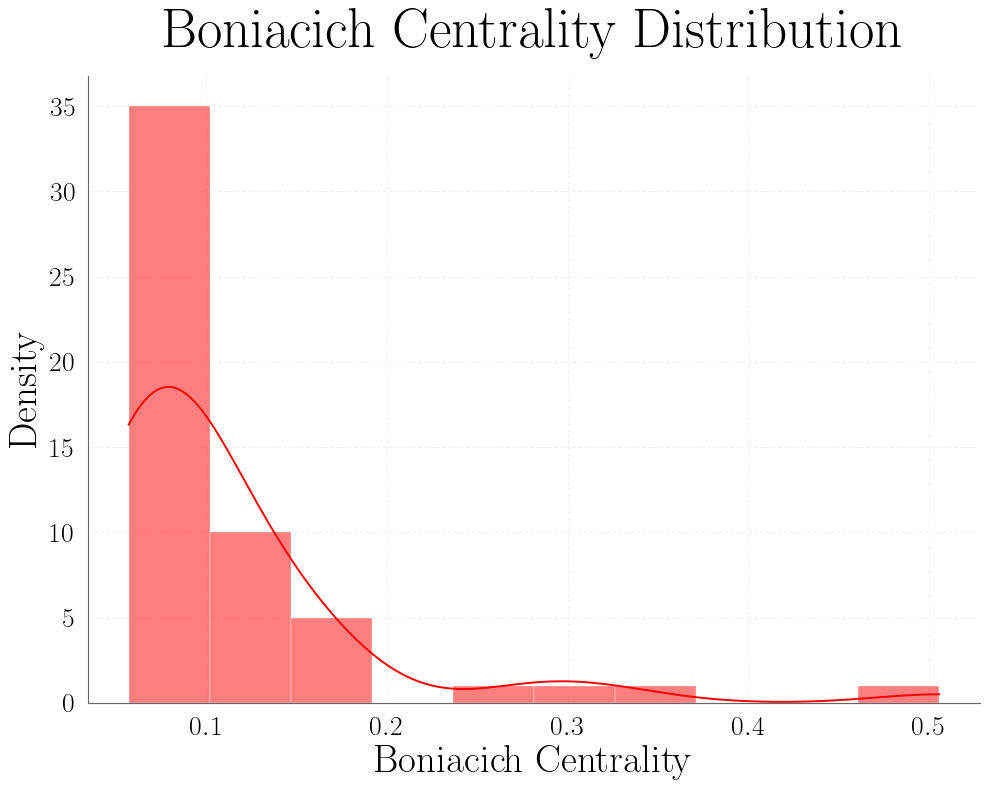

<Figure size 640x440 with 0 Axes>

In [93]:
# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10, 8))

# Create histogram with KDE
sns.histplot(eigenvector_centrality_values, element='bars', bins=10, kde=True, ax=ax, 
             alpha=0.5, color='green',  # Set alpha for the bins
             legend=False)  # Remove the legend

for patch in ax.patches:
    patch.set_facecolor((1, 0, 0, 0.5))

ax.lines[0].set_color('red')

# Style the grid
ax.grid(True, which='major', linestyle='--', alpha=0.2)
ax.set_axisbelow(True)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Style the remaining spines
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')

# Style the axis labels and title with increased font sizes
ax.set_xlabel('Boniacich Centrality', fontsize=28, color='black')  # Increased fontsize
ax.set_ylabel('Density', fontsize=28, color='black')  # Increased fontsize
# ax.set_title('Boniacich Centrality Distribution', 
#              fontsize=24, color='black', pad=20)  # Increased fontsize
ax.set_title('Boniacich Centrality Distribution', 
             fontsize=40, color='black', pad=20)  # Increased fontsize


# Style the ticks with increased font size
ax.tick_params(axis='both', which='major', labelsize=20, colors='black')  # Increased labelsize

# Add some padding
plt.tight_layout()
plt.show()

plt.savefig('plots/DEU_eigenvector.png')

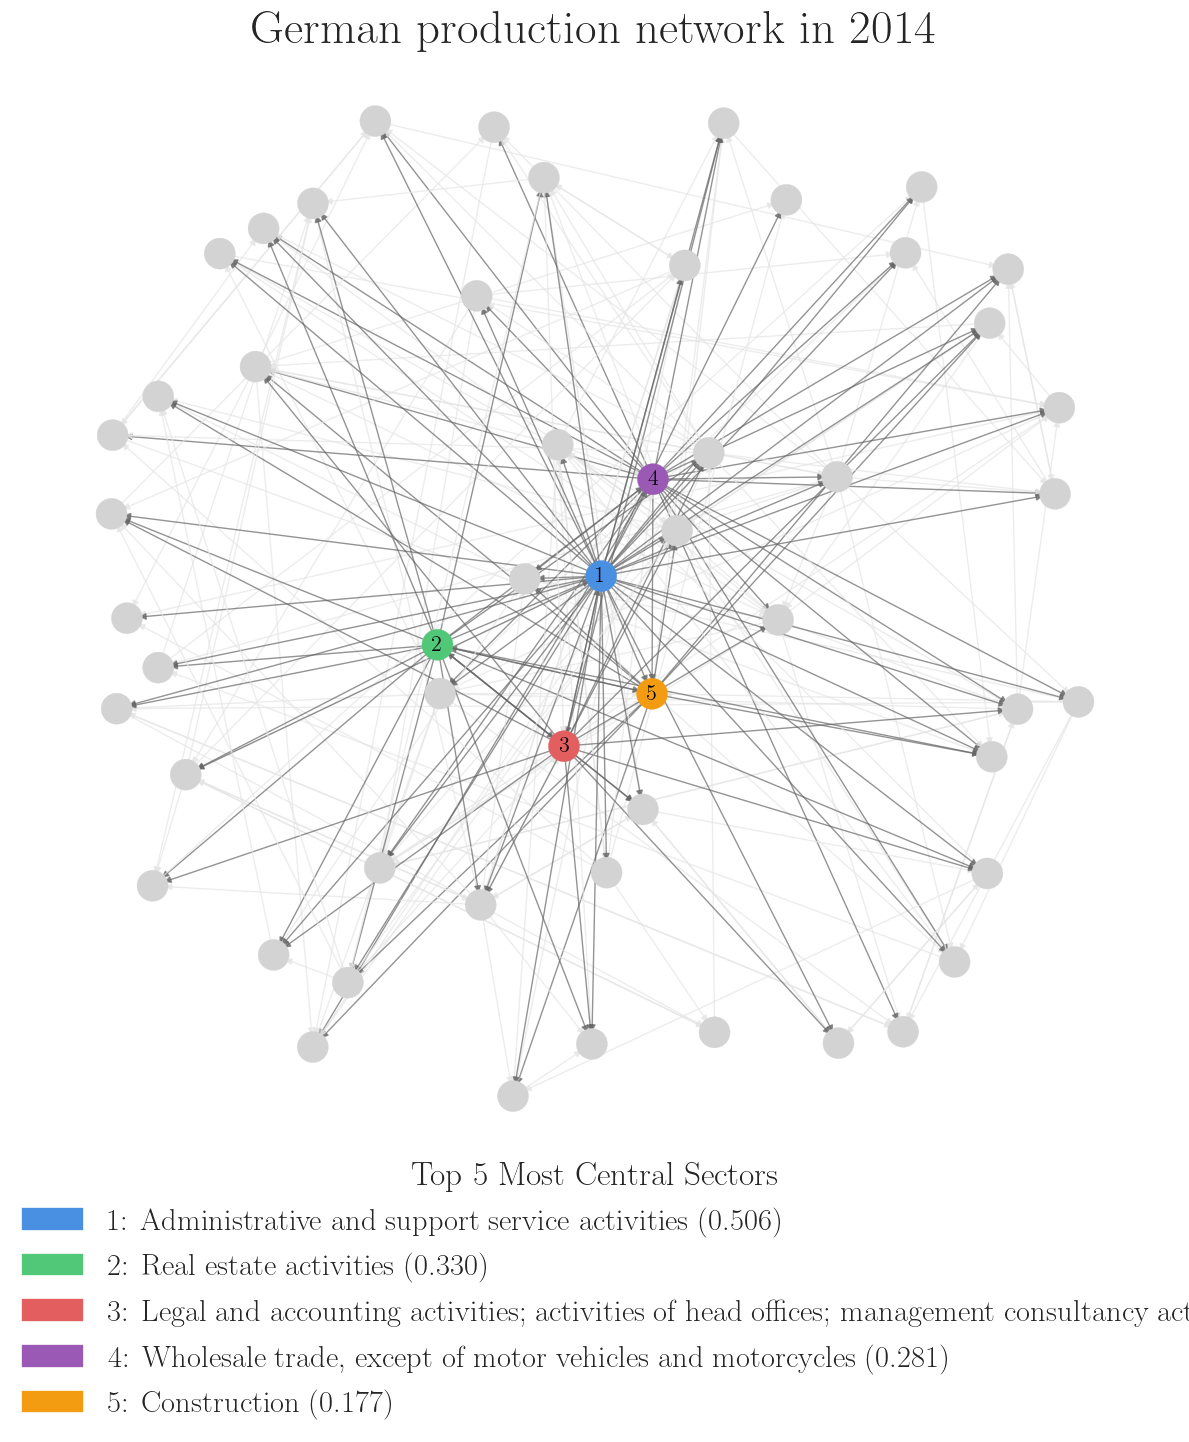

<Figure size 640x440 with 0 Axes>

In [94]:
# Identify the top 5 nodes with highest centrality
top_5_nodes = sorted(boniachich_centrality, key=boniachich_centrality.get, reverse=True)[:5]

# Define distinct colors for top 5 nodes
distinct_colors = {
    top_5_nodes[0]: '#4a90e2',  # blue
    top_5_nodes[1]: '#50c878',  # green
    top_5_nodes[2]: '#e35f5f',  # red
    top_5_nodes[3]: '#9b59b6',  # purple
    top_5_nodes[4]: '#f39c12',  # orange
}

# Create node colors list
node_colors = []
for node in G.nodes():
    if node in top_5_nodes:
        node_colors.append(distinct_colors[node])
    else:
        node_colors.append('#D3D3D3')  # light grey for other nodes

# Create edge colors - dark grey for edges FROM central nodes, light grey for others
edge_colors = []
for u, v in G.edges():  # Look at source (u) and target (v) nodes
    if u in top_5_nodes:  # Only check if source node is in top 5
        edge_colors.append('#666666')  # darker grey for edges FROM central nodes
    else:
        edge_colors.append('#E5E5E5')  # light grey for other edges

plt.figure(figsize=(12, 15))  # Adjusted to maintain square plot area with legend

# Create subplot for the network
ax1 = plt.subplot2grid((13, 12), (0, 0), colspan=12, rowspan=12)
ax1.grid(False)
ax1.set_frame_on(False)

# Calculate spring layout with iterations
pos = nx.spring_layout(G, k=1.5, iterations=50)  # k=1.5 for more spread, 50 iterations for better convergence

# Ensure the plot is perfectly square
ax1.set_aspect('equal')

# Draw nodes
nx.draw_networkx_nodes(G, pos, 
                      node_color=node_colors,
                      node_size=500)

# Draw edges
nx.draw_networkx_edges(G, pos, 
                      edgelist=G.edges(), 
                      width=1.0,
                      edge_color=edge_colors, 
                      alpha=0.7,
                      arrows=True,  # Show arrow direction
                      arrowsize=10)  # Size of arrow head

# Add labels for top 5 nodes (all in black)
for i, node in enumerate(top_5_nodes, start=1):
    x, y = pos[node]
    plt.text(x, y, str(i), fontsize=16, ha='center', va='center',  # Increased fontsize
             color='black',
             fontweight='bold')

# Create subplot for the legend
ax2 = plt.subplot2grid((13, 12), (12, 0), colspan=12, rowspan=1)
ax2.grid(False)
ax2.axis('off')

# Create legend for top 5 nodes
legend_handles = []
for i, node in enumerate(top_5_nodes):
    legend_handles.append(mpatches.Patch(
        color=distinct_colors[node],
        label=f'{i+1}: {variable_descriptions[node]} ({boniachich_centrality[node]:.3f})'
    ))

# Place legend in the bottom subplot
ax2.legend(handles=legend_handles,
          loc='center',
          fontsize=22,  # Increased fontsize for legend
          title="Top 5 Most Central Sectors",
          title_fontsize=24,  # Increased title fontsize for legend
          ncol=1,
          bbox_to_anchor=(0, 0, 1, 1),
          borderaxespad=0,
          mode='expand',
          frameon=False)

# plt.suptitle(f'Production Network for {country} in {YEAR}', y=0.95, fontsize=24)  # Increased fontsize for title
plt.suptitle(f'German production network in {YEAR}', y=0.95, fontsize=34)  # Increased fontsize for title
plt.tight_layout()
plt.show()

plt.savefig('plots/DEU_centrality.png')